In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
faber24_lcc_fasd_path = kagglehub.dataset_download('faber24/lcc-fasd')

print(faber24_lcc_fasd_path)
print('Data source import complete.')


Using Colab cache for faster access to the 'lcc-fasd' dataset.
/kaggle/input/lcc-fasd
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

from __future__ import absolute_import, division, print_function, unicode_literals

import os
import glob
import shutil
from tqdm import tqdm

import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg

# Import packages for data handling
from PIL import Image
from skimage.io import imread
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from mlxtend.plotting import plot_confusion_matrix

# pytorch
import torch
import torch.nn as nn
from torch.nn.functional import softmax
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.models import mobilenet_v2

# from albumentations.augmentations.blur import MotionBlur, Defocus # Old import
import albumentations as A
from albumentations import MotionBlur, Defocus # Corrected import
from albumentations.pytorch import ToTensorV2


import warnings
warnings.filterwarnings('ignore')

color = sns.color_palette()
%matplotlib inline

# Set seed nunmber to all packages
seed_number = 42
np.random.seed(seed_number)

In [ ]:
# Configuring directories

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
root = "/kaggle/input/lcc-fasd"
input_dir = os.path.join(root,"LCC_FASD")
train_dir = os.path.join(input_dir, 'LCC_FASD_training')
val_dir = os.path.join(input_dir, 'LCC_FASD_development')
test_dir = os.path.join(input_dir, 'LCC_FASD_evaluation')

dataset_dir = [dir for dir in sorted(os.listdir(input_dir)) if os.path.isdir(os.path.join(input_dir, dir))]
label_name = [subdir for subdir in sorted(os.listdir(train_dir)) if os.path.isdir(os.path.join(train_dir, subdir))]

# Printing the directory informations
print(f"Main directories\t: {os.listdir(root)}")
print(f"Dataset sub-directories\t: {dataset_dir}")
print(f"Train set directory\t: {label_name}")

Main directories	: ['LCC_FASD']
Dataset sub-directories	: ['LCC_FASD_development', 'LCC_FASD_evaluation', 'LCC_FASD_training']
Train set directory	: ['real', 'spoof']


In [ ]:
dir_dict = {'train': train_dir, 'val': val_dir, 'test': test_dir}
case_count, img_disp, set_length  = {}, {}, {}

for key, val in dir_dict.items():
    case_count[key] = {}
    img_disp[key] = {}
    set_count = 0

    for label in label_name:
        label_list = list(sorted(glob.glob(os.path.join(val, label, "*.png"))))
        if len(label_list) == 0:
            continue

        case_count[key][label] = len(label_list)
        set_count += len(label_list)

        select_img_id = np.random.randint(len(label_list)-1)
        # print(select_img_id)
        img_disp[key][label] = label_list[select_img_id]

    set_length[key] = set_count

case_count_df = pd.DataFrame(case_count)
img_disp_df = pd.DataFrame(img_disp)
print(f"Dataset summary:\n\n{case_count_df}")

Dataset summary:

       train   val  test
real    1223   405   314
spoof   7076  2543  7266


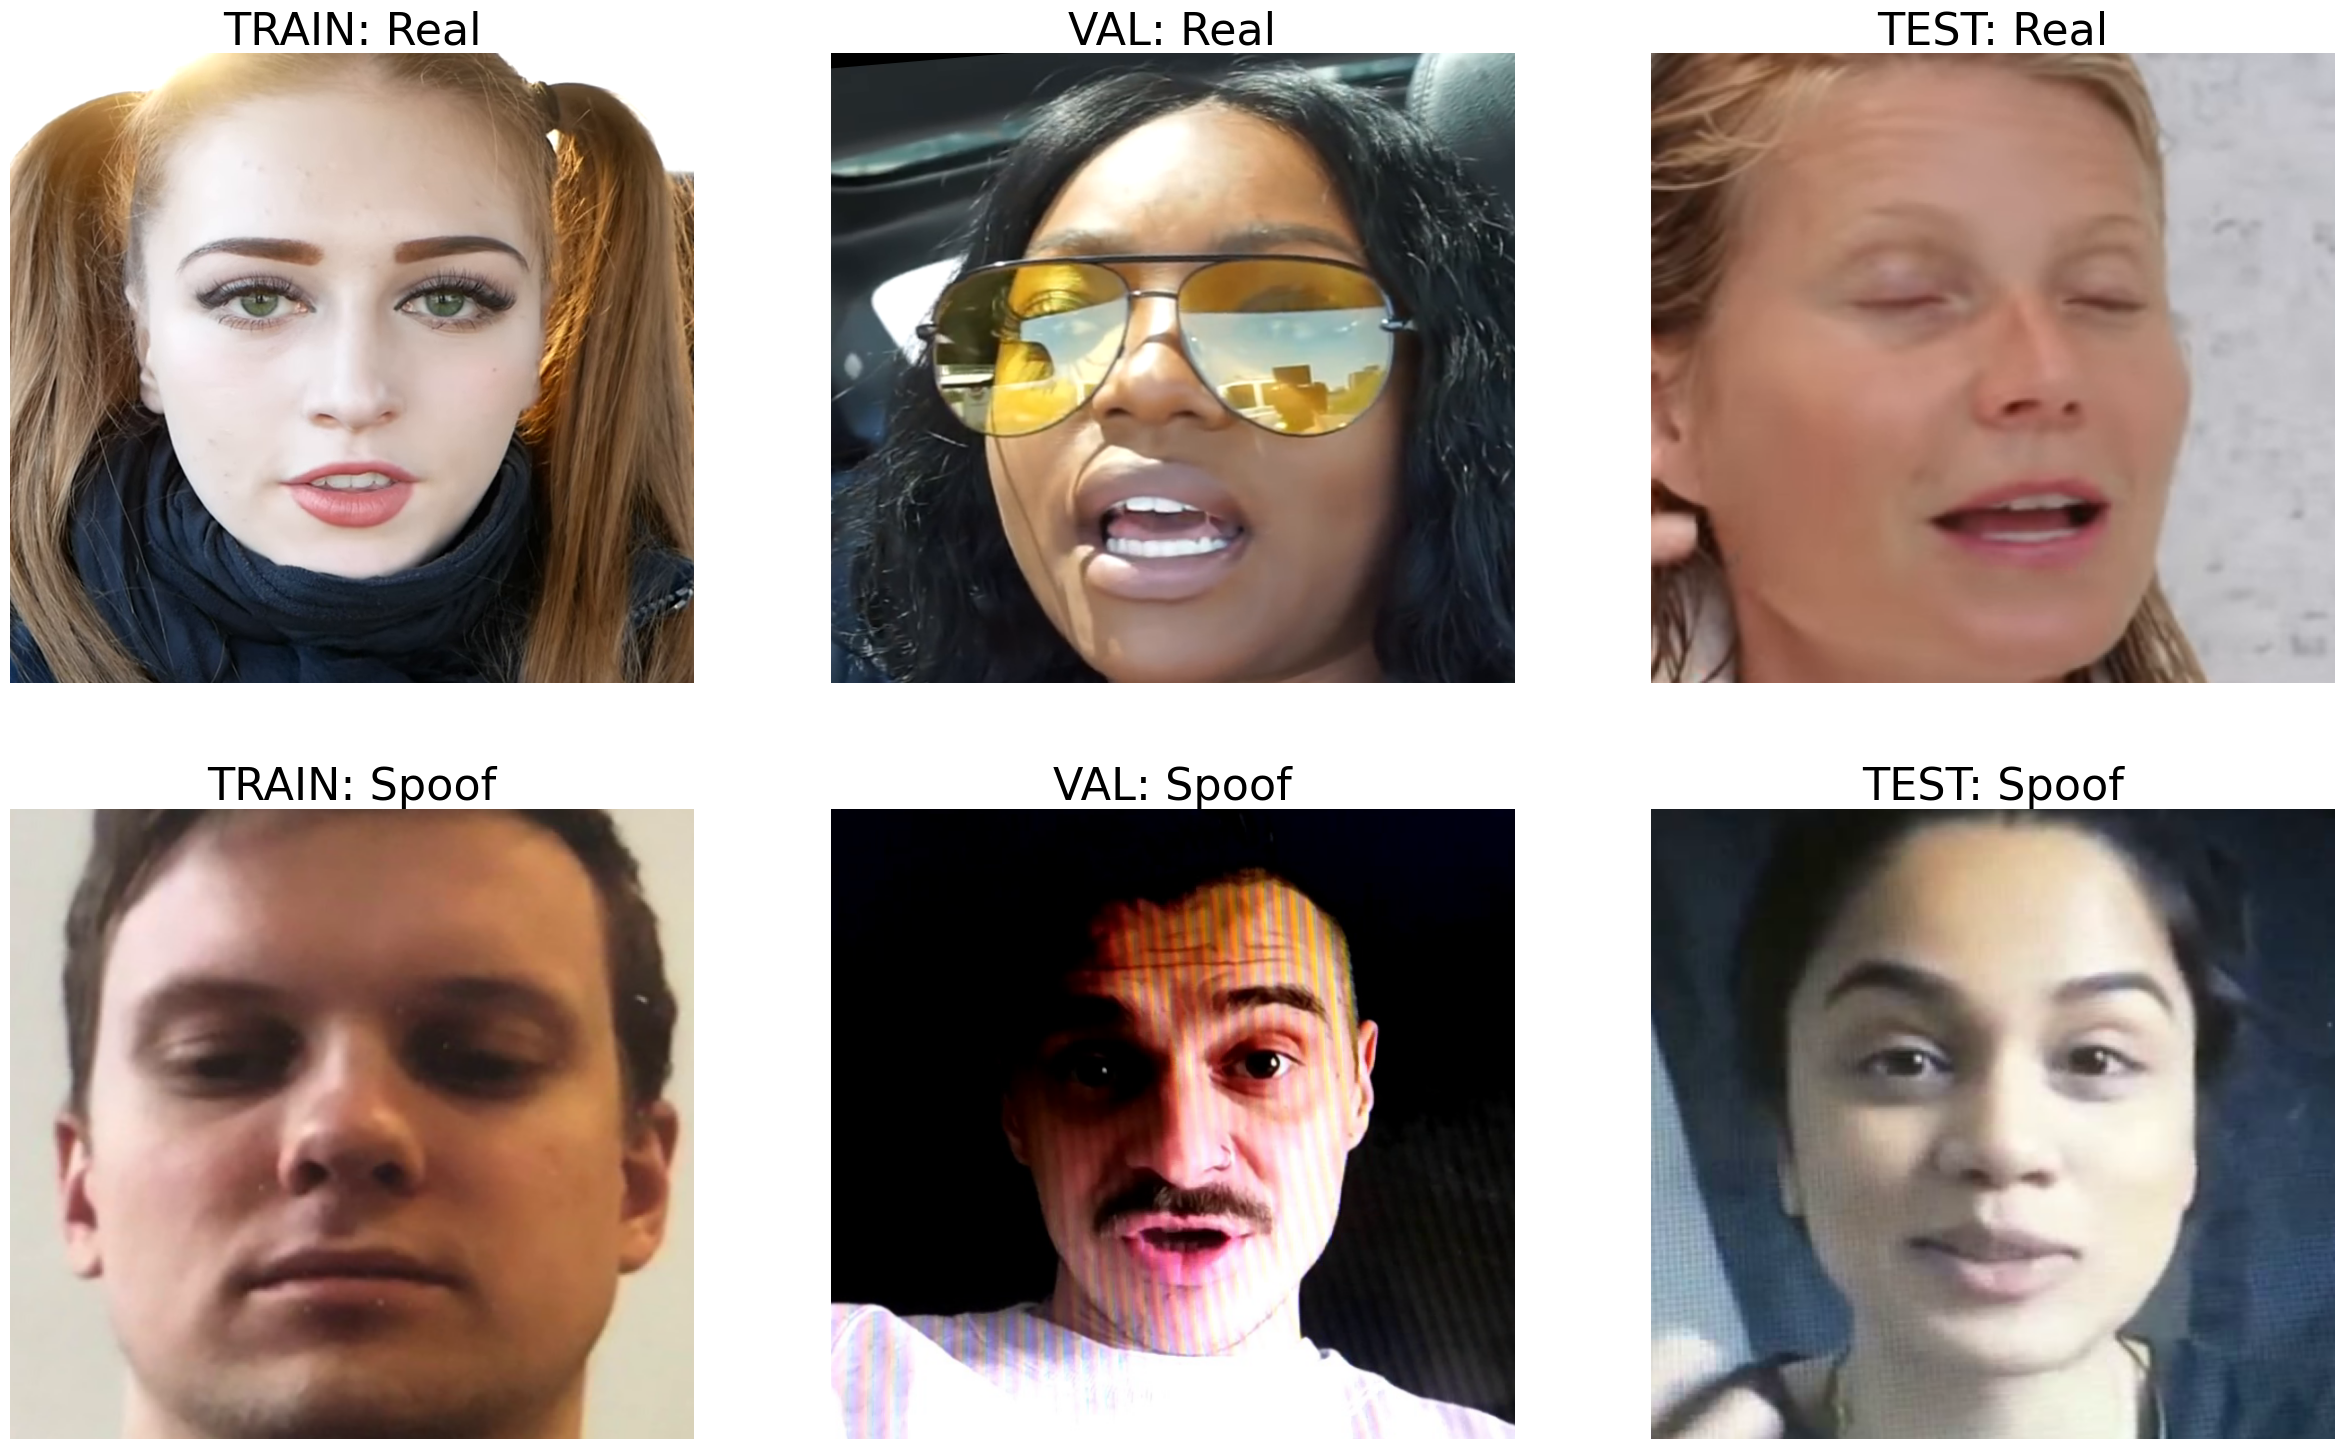

In [ ]:
# Visualizing some of the data set
num_classes = len(label_name)
num_dataset = 0
for key, val in set_length.items():
  num_dataset += 1 if val > 0 else 0

f, ax = plt.subplots(num_classes, num_dataset, figsize=(num_dataset*10, 18))

for k in range(num_classes*num_dataset):
    j, i = k//num_dataset, k%num_dataset  # Image indexing

    img = imread(img_disp_df.iloc[j, i])
    ax[j, i].imshow(img, cmap='gray')
    ax[j, i].set_title(f"{img_disp_df.columns[i].upper()}: {img_disp_df.index[j].capitalize()}", fontsize=32)
    ax[j, i].axis('off')
    ax[j, i].set_aspect('auto')
plt.show()

**Preprocessing**

In [ ]:
# Define the data transformations for training, validation, and testing
# train_transform = transforms.Compose([
#     transforms.RandomResizedCrop(224),
#     transforms.RandomRotation(20),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=0.15),
# #     transforms.RandomZoom(0.15),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])
train_transform = A.Compose([
    A.Resize(224, 224, interpolation=cv2.INTER_CUBIC),
    A.ISONoise(
        color_shift=(0.15, 0.35),
        intensity=(0.1, 0.5),
        always_apply=False,
        p=0.05),
    A.RandomBrightnessContrast(
        brightness_limit=(-0.2, 0.2),
        contrast_limit=(-0.2, 0.2),
        always_apply=False,
        brightness_by_max=True, p=0.125),
    A.MotionBlur(blur_limit=3, p=0.2),
    A.ImageCompression(
        quality_lower=50,
        quality_upper=100,
        always_apply=False,
        p=0.25),
    A.CoarseDropout(
        max_holes=24,
        max_height=8,
        max_width=8,
        min_holes=4,
        min_height=4,
        min_width=4,
        fill_value=0,
        always_apply=False,
        p=0.25),
    A.GaussNoise(
        var_limit=(10.0, 50.0),
        mean=0,
        always_apply=False,
        p=0.2),
    A.ShiftScaleRotate(scale_limit=0.2, rotate_limit=0, shift_limit=0, p=1.0),
    A.ShiftScaleRotate(
        shift_limit=0.1,
        scale_limit=0.1,
        rotate_limit=15,
        interpolation=cv2.INTER_CUBIC,
        border_mode=cv2.BORDER_REFLECT_101,
        always_apply=False,
        p=0.5),
    A.Affine(
        scale=(0.5, 1.5),
        translate_percent=(0.1, 0.2),
        rotate=(-15, 15),
        shear=(-8, 8),
        interpolation=cv2.INTER_CUBIC,
        always_apply=False,
        p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# val_transform = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# test_transform = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])


val_transform = A.Compose([
    A.Resize(224, 224, interpolation=cv2.INTER_CUBIC),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    # To tensor
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(224, 224, interpolation=cv2.INTER_CUBIC),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    # To tensor
    ToTensorV2(),
])

**Prepare Datasets**

In [ ]:
def gen_df(img_dir):
    real_img_dir = os.path.join(img_dir, 'real')
    spoof_img_dir = os.path.join(img_dir, 'spoof')
    real_files = [os.path.join(real_img_dir, f) for f in os.listdir(real_img_dir) if os.path.isfile(os.path.join(real_img_dir, f))]
    spoof_files = [os.path.join(spoof_img_dir, f) for f in os.listdir(spoof_img_dir) if os.path.isfile(os.path.join(spoof_img_dir, f))]

    # Create DataFrame
    data = {
        'file_path': real_files + spoof_files,
        'live': [1] * len(real_files) + [0] * len(spoof_files)
    }

    df = pd.DataFrame(data)
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    return df

In [ ]:
df_train = gen_df(dir_dict['train'])
df_val = gen_df(dir_dict['val'])
df_test = gen_df(dir_dict['test'])

In [ ]:
df_train['live'].value_counts()

,count
live,
0,7076
1,1223


In [ ]:
df_train['file_path'][0]

'/kaggle/input/lcc-fasd/LCC_FASD/LCC_FASD_training/spoof/YOUTUBE_HP17AN005NT_UNKNOWN_id34_s0_45.png'

In [ ]:
df_train['live'][0]

np.int64(0)

In [ ]:
df_train_0 = df_train[df_train['live']==0][:1223]
df_train_1 = df_train[df_train['live']==1][:1223]
df_train_balanced = pd.concat([df_train_0, df_train_1]).reset_index(drop=True)
df_train_balanced = df_train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
df_train_balanced

,file_path,live
0,/kaggle/input/lcc-fasd/LCC_FASD/LCC_FASD_train...,1
1,/kaggle/input/lcc-fasd/LCC_FASD/LCC_FASD_train...,1
2,/kaggle/input/lcc-fasd/LCC_FASD/LCC_FASD_train...,0
3,/kaggle/input/lcc-fasd/LCC_FASD/LCC_FASD_train...,1
4,/kaggle/input/lcc-fasd/LCC_FASD/LCC_FASD_train...,0
...,...,...
2441,/kaggle/input/lcc-fasd/LCC_FASD/LCC_FASD_train...,1
2442,/kaggle/input/lcc-fasd/LCC_FASD/LCC_FASD_train...,0
2443,/kaggle/input/lcc-fasd/LCC_FASD/LCC_FASD_train...,0
2444,/kaggle/input/lcc-fasd/LCC_FASD/LCC_FASD_train...,1


In [ ]:
df_train_balanced['live'].value_counts()

,count
live,
1,1223
0,1223


In [ ]:
df_val['live'].value_counts()

,count
live,
0,2543
1,405


In [ ]:
df_val_0 = df_val[df_val['live']==0][:405]
df_val_1 = df_val[df_val['live']==1][:405]
df_val_balanced = pd.concat([df_val_0, df_val_1]).reset_index(drop=True)
df_val_balanced = df_val_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
df_val_balanced['live'].value_counts()

,count
live,
0,405
1,405


In [ ]:
df_test['live'].value_counts()

,count
live,
0,7266
1,314


In [ ]:
df_test_0 = df_test[df_test['live']==0][:314]
df_test_1 = df_test[df_test['live']==1][:314]
df_test_balanced = pd.concat([df_test_0, df_test_1]).reset_index(drop=True)
df_test_balanced = df_test_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
df_test_balanced['live'].value_counts()

,count
live,
1,314
0,314


In [ ]:
# class FASDataset(Dataset):

#     def __init__(self, df, transforms=None):
#         self.df = df
#         self.transforms = transforms

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         img_path = self.df.iloc[idx]['file_path']
#         label = self.df.iloc[idx]['live']
#         label = torch.tensor(label).unsqueeze(0)
#         image = Image.open(img_path)

#         if self.transforms is not None:
#             image = self.transforms(image)

#         return image, label
class FASDataset(Dataset):

    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['file_path']
        label = self.df.iloc[idx]['live']
        label = torch.tensor(label).unsqueeze(0)
        image = Image.open(img_path)
        image = np.array(image)

        if self.transforms is not None:
            image = self.transforms(image=image)['image']

        return image, label

In [ ]:
train_dataset = FASDataset(df_train, train_transform)
val_dataset = FASDataset(df_val, val_transform)
test_dataset = FASDataset(df_test, test_transform)

dataloader_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=32, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
img, label = next(iter(dataloader_train))
img.size(), label.size()

(torch.Size([32, 3, 224, 224]), torch.Size([32, 1]))

**Define Model**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using \'{}\' device'.format(device))

using 'cuda' device


In [ ]:
# import torch
# import torch.nn as nn
# from torchvision.models import mobilenet_v2

# class SpoofNet(nn.Module):
#     def __init__(self):
#         super(SpoofNet, self).__init__()
#         # Load pretrained MobileNetV2
#         self.pretrained_net = mobilenet_v2(pretrained=True)
#         self.features = self.pretrained_net.features

#         # Adding the extra layers
#         self.conv2d = nn.Conv2d(1280, 32, kernel_size=(3, 3), padding=1)  # Adjust input channels if needed
#         self.relu = nn.ReLU()
#         self.dropout1 = nn.Dropout(0.2)
#         self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(32, 1)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         x = self.features(x)
#         x = self.conv2d(x)
#         x = self.relu(x)
#         x = self.dropout1(x)
#         x = self.global_avg_pool(x)
#         x = torch.flatten(x, 1)
#         x = self.fc(x)
#         x = self.sigmoid(x)
#         return x

# # Instantiate the model and print the summary
# model = SpoofNet()
# model.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 81.3MB/s]


SpoofNet(
  (pretrained_net): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_siz

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

class SpoofNet(nn.Module):
    def __init__(self):
        super(SpoofNet, self).__init__()

        ### CHANGE 1: Load pretrained ResNet50 ###
        # Use the modern 'weights' argument for clarity
        self.pretrained_net = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

        ### CHANGE 2: Create a feature extractor from ResNet50 layers ###
        # ResNet50 doesn't have a '.features' attribute like MobileNetV2.
        # We build it by taking all layers except the final pooling and fully connected layers.
        self.features = nn.Sequential(
            self.pretrained_net.conv1,
            self.pretrained_net.bn1,
            self.pretrained_net.relu,
            self.pretrained_net.maxpool,
            self.pretrained_net.layer1,
            self.pretrained_net.layer2,
            self.pretrained_net.layer3,
            self.pretrained_net.layer4
        )

        ### CHANGE 3: Update the input channels for your custom layers ###
        # ResNet50's last feature block outputs 2048 channels.
        self.conv2d = nn.Conv2d(2048, 32, kernel_size=(3, 3), padding=1)

        # The rest of your custom layers remain the same
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # The forward pass logic remains identical
        x = self.features(x)
        x = self.conv2d(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

# Instantiate the new model and move it to the device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpoofNet()
model.to(device)

print("Model with ResNet50 backbone created successfully.")
# You can now proceed with your training

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 152MB/s]


Model with ResNet50 backbone created successfully.


In [ ]:
SpoofNet()

SpoofNet(
  (pretrained_net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

In [ ]:
num_epochs = 10
learning_rate = 5e-5

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()
scheduler = ReduceLROnPlateau(
    optimizer, factor=0.2, patience=3,
    threshold=0.005, min_lr=5e-7,
)

# dict to store history
history = {
    'train_loss': [],
    'val_loss': [],
    'train_accuracy': [],
    'val_accuracy': [],
    'learning_rate': [],
}

best_val_loss = 0.0
save_dir = '/content/resnet50_spoof_checkpoint'

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)


# define checkpoint paths
cont_filepath = os.path.join(save_dir, "resnet50-epoch_{}.pt")
best_filepath = os.path.join(save_dir, "resnet50-best.pt")

def save_checkpoint(state, is_best, filename):
    torch.save(state, filename)
    if is_best:
        torch.save(state, best_filepath)

In [ ]:
for epoch in range(num_epochs):
    print('epoch: {}/{}'.format(epoch+1, num_epochs))
    print('-----------------------')
    model.train()
    running_loss = 0.0
    train_total = 0
    train_correct = 0
    prog_bar_train = tqdm(dataloader_train, desc='training')
    for inputs, labels in prog_bar_train:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        predicted = (outputs > 0.5).int()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # update progress
        prog_bar_train.set_postfix({'acc': round(train_correct / train_total, 2)})

    train_acc = 100 * train_correct / train_total
    avg_train_loss = running_loss / len(dataloader_train)

    history['train_loss'].append(avg_train_loss)
    history['train_accuracy'].append(train_acc)

    # validate the model --------------------------------------------------
    model.eval()
    running_val_loss = 0.0
    val_total = 0
    val_correct = 0
    prog_bar_val = tqdm(dataloader_val, desc='validating')
    with torch.no_grad():
        for inputs, labels in prog_bar_val:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            running_val_loss += loss.item()
            predicted = (outputs > 0.5).int()
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # update progress
            prog_bar_val.set_postfix({'acc': round(val_correct / val_total, 4)})


    avg_val_loss = running_val_loss / len(dataloader_val)
    scheduler.step(avg_val_loss)

    val_acc = 100 * val_correct / val_total

    history['val_loss'].append(avg_val_loss)
    history['val_accuracy'].append(val_acc)


    # Check for improvement ---------------------------
    if epoch == 0:
        best_val_loss = avg_val_loss
        is_best = True
    else:
        is_best = avg_val_loss < best_val_loss
        best_val_loss = min(avg_val_loss, best_val_loss)

    checkpoint_filepath = cont_filepath.format(epoch+1)
    print('saving checkpoint: {}'.format(checkpoint_filepath))
    save_checkpoint(
        {'epoch': epoch + 1,
         'state_dict': model.state_dict(),
         'optimizer': optimizer.state_dict(),},
        is_best,
        checkpoint_filepath
    )

    current_lr = optimizer.param_groups[0]['lr']
    history['learning_rate'].append(current_lr)


    # print loss and accuracy
    print(f'Epoch: {epoch+1}/{num_epochs}'),
    print('Loss/train: {}'.format(avg_train_loss))
    print('Loss/val: {}'.format(avg_val_loss))
    print('Acc/train: {}%'.format(train_acc))
    print('Acc/val: {}%'.format(val_acc))
    print('current lr: {}'.format(current_lr))


epoch: 1/10
-----------------------


validating: 100%|██████████| 93/93 [01:01<00:00,  1.50it/s, acc=0.956]


saving checkpoint: /content/resnet50_spoof_checkpoint/resnet50-epoch_1.pt
Epoch: 1/10
Loss/train: 0.24773910879515684
Loss/val: 0.22554977624727193
Acc/train: 89.93854681286902%
Acc/val: 95.5563093622795%
current lr: 5e-05
epoch: 2/10
-----------------------


validating: 100%|██████████| 93/93 [00:49<00:00,  1.88it/s, acc=0.805]


saving checkpoint: /content/resnet50_spoof_checkpoint/resnet50-epoch_2.pt
Epoch: 2/10
Loss/train: 0.18308740149323757
Loss/val: 0.4290574616802636
Acc/train: 93.72213519701168%
Acc/val: 80.49525101763908%
current lr: 5e-05
epoch: 3/10
-----------------------


validating: 100%|██████████| 93/93 [00:49<00:00,  1.88it/s, acc=0.872]


saving checkpoint: /content/resnet50_spoof_checkpoint/resnet50-epoch_3.pt
Epoch: 3/10
Loss/train: 0.1255188531278131
Loss/val: 0.28483776788237275
Acc/train: 95.30063863116038%
Acc/val: 87.21166892808684%
current lr: 5e-05
epoch: 4/10
-----------------------


validating: 100%|██████████| 93/93 [00:50<00:00,  1.85it/s, acc=0.914]


saving checkpoint: /content/resnet50_spoof_checkpoint/resnet50-epoch_4.pt
Epoch: 4/10
Loss/train: 0.10762264804484753
Loss/val: 0.2578049994284107
Acc/train: 95.66212796722496%
Acc/val: 91.45183175033921%
current lr: 5e-05
epoch: 5/10
-----------------------


validating: 100%|██████████| 93/93 [00:50<00:00,  1.86it/s, acc=0.943]


saving checkpoint: /content/resnet50_spoof_checkpoint/resnet50-epoch_5.pt
Epoch: 5/10
Loss/train: 0.09767721282819716
Loss/val: 0.16911701986225702
Acc/train: 96.27665983853477%
Acc/val: 94.3012211668928%
current lr: 5e-05
epoch: 6/10
-----------------------


validating: 100%|██████████| 93/93 [00:50<00:00,  1.85it/s, acc=0.965]


saving checkpoint: /content/resnet50_spoof_checkpoint/resnet50-epoch_6.pt
Epoch: 6/10
Loss/train: 0.09405972812181482
Loss/val: 0.17066405976431503
Acc/train: 96.39715628388963%
Acc/val: 96.47218453188603%
current lr: 5e-05
epoch: 7/10
-----------------------


validating: 100%|██████████| 93/93 [00:50<00:00,  1.86it/s, acc=0.954]


saving checkpoint: /content/resnet50_spoof_checkpoint/resnet50-epoch_7.pt
Epoch: 7/10
Loss/train: 0.08410875652200328
Loss/val: 0.17126970467287847
Acc/train: 96.78274490902518%
Acc/val: 95.3527815468114%
current lr: 5e-05
epoch: 8/10
-----------------------


validating: 100%|██████████| 93/93 [00:50<00:00,  1.86it/s, acc=0.96]


saving checkpoint: /content/resnet50_spoof_checkpoint/resnet50-epoch_8.pt
Epoch: 8/10
Loss/train: 0.07962547938267772
Loss/val: 0.17835403561811516
Acc/train: 96.69839739727678%
Acc/val: 95.99728629579376%
current lr: 5e-05
epoch: 9/10
-----------------------


validating: 100%|██████████| 93/93 [00:49<00:00,  1.88it/s, acc=0.959]


saving checkpoint: /content/resnet50_spoof_checkpoint/resnet50-epoch_9.pt
Epoch: 9/10
Loss/train: 0.07369912658155395
Loss/val: 0.20980152515301753
Acc/train: 97.0237377997349%
Acc/val: 95.92944369063773%
current lr: 1e-05
epoch: 10/10
-----------------------


validating: 100%|██████████| 93/93 [00:50<00:00,  1.86it/s, acc=0.947]


saving checkpoint: /content/resnet50_spoof_checkpoint/resnet50-epoch_10.pt
Epoch: 10/10
Loss/train: 0.06038220665919093
Loss/val: 0.2450036043520286
Acc/train: 97.7226171827931%
Acc/val: 94.74219810040705%
current lr: 1e-05


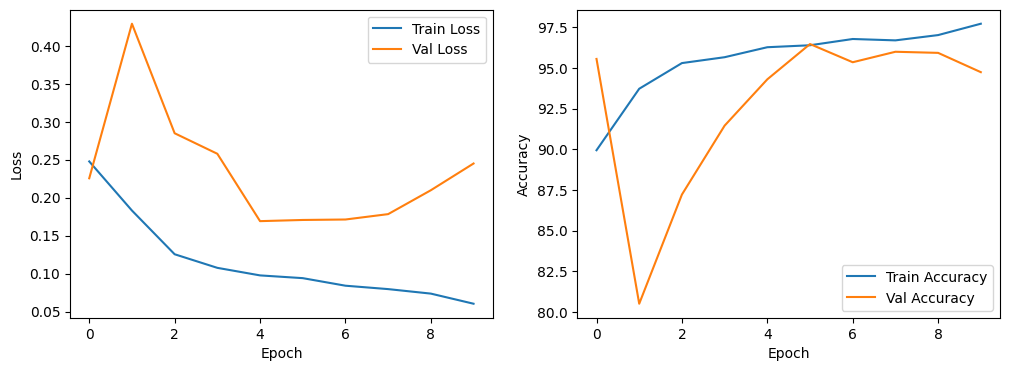

In [ ]:
try:
    # Plot the training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
except:
    print("exception while plotting results")

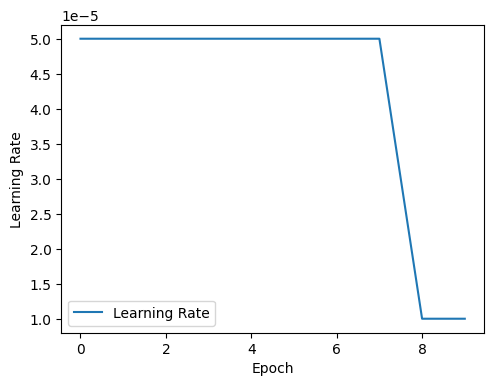

In [ ]:
try:
    plt.figure(figsize=(12, 4))
#     plt.subplot(1, 2, 1)
#     plt.plot(history['train_f1'], label='Train F1')
#     plt.plot(history['val_f1'], label='Val F1')
#     plt.xlabel('Epoch')
#     plt.ylabel('F1')
#     plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['learning_rate'], label='Learning Rate')
#     plt.plot(history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()

    plt.show()
except:
    print("exception while plotting results")

**Evaluation**

In [ ]:
pretrain_weight = '/content/resnet50_spoof_checkpoint/resnet50-best.pt'

In [ ]:
pretrain_weight = '/content/resnet50_spoof_checkpoint/resnet50-best.pt'

In [ ]:
test_loss = 0.0
correct_predictions = 0
total_predictions = 0
prog_bar_test = tqdm(dataloader_test, desc='Testing')

with torch.no_grad():
    for inputs, labels in prog_bar_test:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        test_loss += loss.item()

        predicted = (outputs > 0.5).int()

        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)
        prog_bar_test.set_postfix({
            'accuracy': correct_predictions / total_predictions * 100,
        })

# Calculate average loss and accuracy
test_loss /= len(dataloader_test)
accuracy = correct_predictions / total_predictions * 100

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {accuracy:.2f}%')

Testing: 100%|██████████| 237/237 [02:38<00:00,  1.50it/s, accuracy=94.1]

Test Loss: 0.1647
Test Accuracy: 94.12%


# Training from checkpoint
Provide Python code to resume training of a ResNet50 model from a saved checkpoint.

## Load checkpoint

### Subtask:
Load the saved checkpoint dictionary containing the model's state dictionary, optimizer's state dictionary, and the epoch number.


**Reasoning**:
Load the saved checkpoint dictionary.



In [ ]:
check_point = torch.load(pretrain_weight)
model_dict = check_point['state_dict']
start_epoch = check_point['epoch']

## Initialize model and optimizer

### Subtask:
Instantiate the model and optimizer as you did during the initial training setup.


**Reasoning**:
Instantiate the SpoofNet model, move it to the device, and initialize the optimizer.



In [ ]:
model = SpoofNet()
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Re-initialize the scheduler with the optimizer
scheduler = ReduceLROnPlateau(
    optimizer, factor=0.2, patience=3,
    threshold=0.005, min_lr=5e-7,
)

**Reasoning**:
Load the model and optimizer state dictionaries from the loaded checkpoint.



In [ ]:
model.load_state_dict(model_dict)
optimizer.load_state_dict(check_point['optimizer'])
# Load the scheduler state
if 'scheduler' in check_point:
    scheduler.load_state_dict(check_point['scheduler'])

In [ ]:
num_epochs = 30

## Resume training

### Subtask:
Start the training loop from the epoch number loaded from the checkpoint.


**Reasoning**:
Iterate through the epochs starting from `start_epoch` up to `num_epochs` and print the current epoch and a separator.



In [ ]:
for epoch in range(start_epoch, num_epochs):
    print('epoch: {}/{}'.format(epoch+1, num_epochs))
    print('-----------------------')
    # ... rest of the training loop ...

epoch: 6/30
-----------------------
epoch: 7/30
-----------------------
epoch: 8/30
-----------------------
epoch: 9/30
-----------------------
epoch: 10/30
-----------------------
epoch: 11/30
-----------------------
epoch: 12/30
-----------------------
epoch: 13/30
-----------------------
epoch: 14/30
-----------------------
epoch: 15/30
-----------------------
epoch: 16/30
-----------------------
epoch: 17/30
-----------------------
epoch: 18/30
-----------------------
epoch: 19/30
-----------------------
epoch: 20/30
-----------------------
epoch: 21/30
-----------------------
epoch: 22/30
-----------------------
epoch: 23/30
-----------------------
epoch: 24/30
-----------------------
epoch: 25/30
-----------------------
epoch: 26/30
-----------------------
epoch: 27/30
-----------------------
epoch: 28/30
-----------------------
epoch: 29/30
-----------------------
epoch: 30/30
-----------------------


## Continue training loop

### Subtask:
Implement or reuse the existing training loop, which will now continue from the loaded state.


**Reasoning**:
Implement or reuse the existing training loop, which will now continue from the loaded state.



In [ ]:
for epoch in range(start_epoch, num_epochs):
    print('epoch: {}/{}'.format(epoch+1, num_epochs))
    print('-----------------------')
    model.train()
    running_loss = 0.0
    train_total = 0
    train_correct = 0
    prog_bar_train = tqdm(dataloader_train, desc='training')
    for inputs, labels in prog_bar_train:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        predicted = (outputs > 0.5).int()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # update progress
        prog_bar_train.set_postfix({'acc': round(train_correct / train_total, 2)})

    train_acc = 100 * train_correct / train_total
    avg_train_loss = running_loss / len(dataloader_train)

    history['train_loss'].append(avg_train_loss)
    history['train_accuracy'].append(train_acc)

    # validate the model --------------------------------------------------
    model.eval()
    running_val_loss = 0.0
    val_total = 0
    val_correct = 0
    prog_bar_val = tqdm(dataloader_val, desc='validating')
    with torch.no_grad():
        for inputs, labels in prog_bar_val:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            running_val_loss += loss.item()
            predicted = (outputs > 0.5).int()
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # update progress
            prog_bar_val.set_postfix({'acc': round(val_correct / val_total, 4)})


    avg_val_loss = running_val_loss / len(dataloader_val)
    scheduler.step(avg_val_loss)

    val_acc = 100 * val_correct / val_total

    history['val_loss'].append(avg_val_loss)
    history['val_accuracy'].append(val_acc)


    # Check for improvement ---------------------------
    if epoch == 0:
        best_val_loss = avg_val_loss
        is_best = True
    else:
        is_best = avg_val_loss < best_val_loss
        best_val_loss = min(avg_val_loss, best_val_loss)

    checkpoint_filepath = cont_filepath.format(epoch+1)
    print('saving checkpoint: {}'.format(checkpoint_filepath))
    save_checkpoint(
        {'epoch': epoch + 1,
         'state_dict': model.state_dict(),
         'optimizer': optimizer.state_dict(),
         'scheduler': scheduler.state_dict()}, # Save scheduler state
        is_best,
        checkpoint_filepath
    )

    current_lr = optimizer.param_groups[0]['lr']
    history['learning_rate'].append(current_lr)


    # print loss and accuracy
    print(f'Epoch: {epoch+1}/{num_epochs}'),
    print('Loss/train: {}'.format(avg_train_loss))
    print('Loss/val: {}'.format(avg_val_loss))
    print('Acc/train: {}%'.format(train_acc))
    print('Acc/val: {}%'.format(val_acc))
    print('current lr: {}'.format(current_lr))

epoch: 6/30
-----------------------


validating: 100%|██████████| 93/93 [00:51<00:00,  1.81it/s, acc=0.953]


saving checkpoint: /content/resnet50_spoof_checkpoint/resnet50-epoch_6.pt
Epoch: 6/30
Loss/train: 0.08874127876300078
Loss/val: 0.20727463267112692
Acc/train: 96.56585130738644%
Acc/val: 95.28493894165535%
current lr: 5e-05
epoch: 7/30
-----------------------


validating: 100%|██████████| 93/93 [00:51<00:00,  1.81it/s, acc=0.918]


saving checkpoint: /content/resnet50_spoof_checkpoint/resnet50-epoch_7.pt
Epoch: 7/30
Loss/train: 0.0813593228168499
Loss/val: 0.259140780385864
Acc/train: 96.91529099891554%
Acc/val: 91.82496607869743%
current lr: 5e-05
epoch: 8/30
-----------------------


validating: 100%|██████████| 93/93 [00:50<00:00,  1.85it/s, acc=0.924]


saving checkpoint: /content/resnet50_spoof_checkpoint/resnet50-epoch_8.pt
Epoch: 8/30
Loss/train: 0.08474087334739475
Loss/val: 0.22018143896674436
Acc/train: 96.65019881913483%
Acc/val: 92.40162822252374%
current lr: 5e-05
epoch: 9/30
-----------------------


validating: 100%|██████████| 93/93 [00:50<00:00,  1.85it/s, acc=0.934]


saving checkpoint: /content/resnet50_spoof_checkpoint/resnet50-epoch_9.pt
Epoch: 9/30
Loss/train: 0.08482889314003002
Loss/val: 0.23125876822278543
Acc/train: 96.81889384263164%
Acc/val: 93.41926729986432%
current lr: 5e-05
epoch: 10/30
-----------------------


validating: 100%|██████████| 93/93 [00:50<00:00,  1.84it/s, acc=0.946]


saving checkpoint: /content/resnet50_spoof_checkpoint/resnet50-epoch_10.pt
Epoch: 10/30
Loss/train: 0.07109475014417863
Loss/val: 0.14559745065046734
Acc/train: 97.01168815519942%
Acc/val: 94.640434192673%
current lr: 5e-05
epoch: 11/30
-----------------------


validating: 100%|██████████| 93/93 [00:50<00:00,  1.83it/s, acc=0.953]


saving checkpoint: /content/resnet50_spoof_checkpoint/resnet50-epoch_11.pt
Epoch: 11/30
Loss/train: 0.07410254836476479
Loss/val: 0.18794012713115862
Acc/train: 97.16833353416074%
Acc/val: 95.25101763907735%
current lr: 5e-05
epoch: 12/30
-----------------------


validating: 100%|██████████| 93/93 [00:51<00:00,  1.81it/s, acc=0.946]


saving checkpoint: /content/resnet50_spoof_checkpoint/resnet50-epoch_12.pt
Epoch: 12/30
Loss/train: 0.07864043559664144
Loss/val: 0.18454989646711656
Acc/train: 96.91529099891554%
Acc/val: 94.640434192673%
current lr: 5e-05
epoch: 13/30
-----------------------


validating: 100%|██████████| 93/93 [00:51<00:00,  1.82it/s, acc=0.951]


saving checkpoint: /content/resnet50_spoof_checkpoint/resnet50-epoch_13.pt
Epoch: 13/30
Loss/train: 0.06739849370743077
Loss/val: 0.21892917357132669
Acc/train: 97.69851789372214%
Acc/val: 95.04748982360923%
current lr: 5e-05
epoch: 14/30
-----------------------


validating: 100%|██████████| 93/93 [00:50<00:00,  1.83it/s, acc=0.92]


saving checkpoint: /content/resnet50_spoof_checkpoint/resnet50-epoch_14.pt
Epoch: 14/30
Loss/train: 0.0604065827282074
Loss/val: 0.3356527956102484
Acc/train: 97.54187251476081%
Acc/val: 92.02849389416554%
current lr: 5e-05
epoch: 15/30
-----------------------


validating: 100%|██████████| 93/93 [00:51<00:00,  1.79it/s, acc=0.92]


saving checkpoint: /content/resnet50_spoof_checkpoint/resnet50-epoch_15.pt
Epoch: 15/30
Loss/train: 0.06296760763775987
Loss/val: 0.30448433445386025
Acc/train: 97.7346668273286%
Acc/val: 91.9606512890095%
current lr: 5e-05
epoch: 16/30
-----------------------


validating: 100%|██████████| 93/93 [00:51<00:00,  1.82it/s, acc=0.964]


saving checkpoint: /content/resnet50_spoof_checkpoint/resnet50-epoch_16.pt
Epoch: 16/30
Loss/train: 0.06753262821943141
Loss/val: 0.2594681130403744
Acc/train: 97.44547535847693%
Acc/val: 96.37042062415196%
current lr: 5e-05
epoch: 17/30
-----------------------


validating: 100%|██████████| 93/93 [00:50<00:00,  1.85it/s, acc=0.923]


saving checkpoint: /content/resnet50_spoof_checkpoint/resnet50-epoch_17.pt
Epoch: 17/30
Loss/train: 0.057910396055264685
Loss/val: 0.2710799625924518
Acc/train: 97.8069646945415%
Acc/val: 92.33378561736771%
current lr: 5e-05
epoch: 18/30
-----------------------


validating: 100%|██████████| 93/93 [00:50<00:00,  1.84it/s, acc=0.961]


saving checkpoint: /content/resnet50_spoof_checkpoint/resnet50-epoch_18.pt
Epoch: 18/30
Loss/train: 0.055741684501901125
Loss/val: 0.2306087982943482
Acc/train: 97.7226171827931%
Acc/val: 96.0651289009498%
current lr: 5e-05
epoch: 19/30
-----------------------


validating: 100%|██████████| 93/93 [00:51<00:00,  1.80it/s, acc=0.961]


saving checkpoint: /content/resnet50_spoof_checkpoint/resnet50-epoch_19.pt
Epoch: 19/30
Loss/train: 0.06192528030906732
Loss/val: 0.21053399466246026
Acc/train: 97.52982287022533%
Acc/val: 96.13297150610583%
current lr: 5e-05
epoch: 20/30
-----------------------


validating: 100%|██████████| 93/93 [00:51<00:00,  1.82it/s, acc=0.941]


saving checkpoint: /content/resnet50_spoof_checkpoint/resnet50-epoch_20.pt
Epoch: 20/30
Loss/train: 0.05227066347959827
Loss/val: 0.2769036824534577
Acc/train: 97.96361007350284%
Acc/val: 94.06377204884667%
current lr: 5e-05
epoch: 21/30
-----------------------


validating: 100%|██████████| 93/93 [00:50<00:00,  1.86it/s, acc=0.955]


saving checkpoint: /content/resnet50_spoof_checkpoint/resnet50-epoch_21.pt
Epoch: 21/30
Loss/train: 0.050256086374485254
Loss/val: 0.20352597382315185
Acc/train: 98.10820580792867%
Acc/val: 95.5223880597015%
current lr: 5e-05
epoch: 22/30
-----------------------


validating: 100%|██████████| 93/93 [00:51<00:00,  1.82it/s, acc=0.965]


saving checkpoint: /content/resnet50_spoof_checkpoint/resnet50-epoch_22.pt
Epoch: 22/30
Loss/train: 0.05177181518318741
Loss/val: 0.1980052596070265
Acc/train: 97.98770936257381%
Acc/val: 96.50610583446404%
current lr: 5e-05
epoch: 23/30
-----------------------


validating: 100%|██████████| 93/93 [00:50<00:00,  1.83it/s, acc=0.953]


saving checkpoint: /content/resnet50_spoof_checkpoint/resnet50-epoch_23.pt
Epoch: 23/30
Loss/train: 0.05884437604153601
Loss/val: 0.23810832694445747
Acc/train: 97.83106398361248%
Acc/val: 95.31886024423338%
current lr: 5e-05
epoch: 24/30
-----------------------


validating: 100%|██████████| 93/93 [00:50<00:00,  1.83it/s, acc=0.922]


saving checkpoint: /content/resnet50_spoof_checkpoint/resnet50-epoch_24.pt
Epoch: 24/30
Loss/train: 0.04783061955956957
Loss/val: 0.25969259393210076
Acc/train: 98.13230509699964%
Acc/val: 92.23202170963366%
current lr: 5e-05
epoch: 25/30
-----------------------


validating: 100%|██████████| 93/93 [00:51<00:00,  1.82it/s, acc=0.948]


saving checkpoint: /content/resnet50_spoof_checkpoint/resnet50-epoch_25.pt
Epoch: 25/30
Loss/train: 0.05598844846065801
Loss/val: 0.19222948270767265
Acc/train: 97.84311362814798%
Acc/val: 94.84396200814112%
current lr: 5e-05
epoch: 26/30
-----------------------


validating: 100%|██████████| 93/93 [00:50<00:00,  1.83it/s, acc=0.938]


saving checkpoint: /content/resnet50_spoof_checkpoint/resnet50-epoch_26.pt
Epoch: 26/30
Loss/train: 0.05146870139108684
Loss/val: 0.2599925075274962
Acc/train: 97.98770936257381%
Acc/val: 93.82632293080054%
current lr: 5e-05
epoch: 27/30
-----------------------


validating: 100%|██████████| 93/93 [00:51<00:00,  1.81it/s, acc=0.951]


saving checkpoint: /content/resnet50_spoof_checkpoint/resnet50-epoch_27.pt
Epoch: 27/30
Loss/train: 0.052974033388398734
Loss/val: 0.18397071191771164
Acc/train: 97.96361007350284%
Acc/val: 95.04748982360923%
current lr: 5e-05
epoch: 28/30
-----------------------


validating: 100%|██████████| 93/93 [00:54<00:00,  1.70it/s, acc=0.944]


saving checkpoint: /content/resnet50_spoof_checkpoint/resnet50-epoch_28.pt
Epoch: 28/30
Loss/train: 0.04899830137460063
Loss/val: 0.22472523833544905
Acc/train: 98.21665260874803%
Acc/val: 94.43690637720488%
current lr: 5e-05
epoch: 29/30
-----------------------


validating: 100%|██████████| 93/93 [00:52<00:00,  1.78it/s, acc=0.937]


saving checkpoint: /content/resnet50_spoof_checkpoint/resnet50-epoch_29.pt
Epoch: 29/30
Loss/train: 0.04876628398286322
Loss/val: 0.23537448915823173
Acc/train: 98.04795758525124%
Acc/val: 93.72455902306649%
current lr: 5e-05
epoch: 30/30
-----------------------


validating: 100%|██████████| 93/93 [00:54<00:00,  1.72it/s, acc=0.966]


saving checkpoint: /content/resnet50_spoof_checkpoint/resnet50-epoch_30.pt
Epoch: 30/30
Loss/train: 0.04701906390613518
Loss/val: 0.19106396307742343
Acc/train: 98.10820580792867%
Acc/val: 96.6078697421981%
current lr: 5e-05


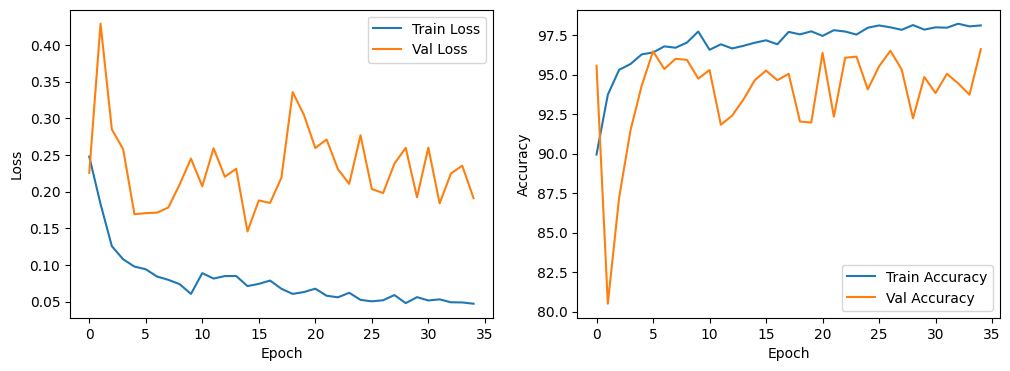

In [ ]:
try:
    # Plot the training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
except:
    print("exception while plotting results")

In [ ]:
y_pred, y_true = [], []
model.eval()
prog_bar_val_report = tqdm(dataloader_val, desc='Generating classification report for validation set')

with torch.no_grad():
    for inputs, labels in prog_bar_val_report:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        # For binary classification with sigmoid output, threshold at 0.5
        predicted = (outputs > 0.5).int()

        y_pred.extend(predicted.squeeze().tolist())
        y_true.extend(labels.squeeze().tolist())

print("\nValidation Classification Report:")
print(classification_report(y_true, y_pred))

Generating classification report for validation set: 100%|██████████| 93/93 [00:54<00:00,  1.70it/s]


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2543
           1       0.86      0.90      0.88       405

    accuracy                           0.97      2948
   macro avg       0.92      0.94      0.93      2948
weighted avg       0.97      0.97      0.97      2948



In [ ]:
y_pred_test, y_true_test = [], []
model.eval()
prog_bar_test_report = tqdm(dataloader_test, desc='Generating classification report for test set')

with torch.no_grad():
    for inputs, labels in prog_bar_test_report:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        # For binary classification with sigmoid output, threshold at 0.5
        predicted = (outputs > 0.5).int()

        y_pred_test.extend(predicted.squeeze().tolist())
        y_true_test.extend(labels.squeeze().tolist())

print("\nTest Classification Report:")
print(classification_report(y_true_test, y_pred_test))

Generating classification report for test set: 100%|██████████| 237/237 [02:05<00:00,  1.90it/s]


Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      7266
           1       0.50      0.87      0.63       314

    accuracy                           0.96      7580
   macro avg       0.75      0.92      0.81      7580
weighted avg       0.97      0.96      0.96      7580



In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          percentify_numbers = True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """

    if percentify_numbers:
        cm = (100 * cm / cm.sum()).round().astype(int)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

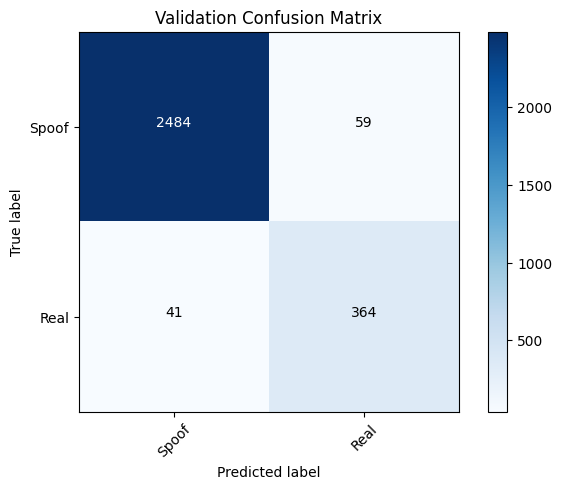

In [ ]:
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
classes = ['Spoof', 'Real']
plot_confusion_matrix(cm,
                      classes=classes,
                      percentify_numbers = False,
                      title="Validation Confusion Matrix")

plt.show()

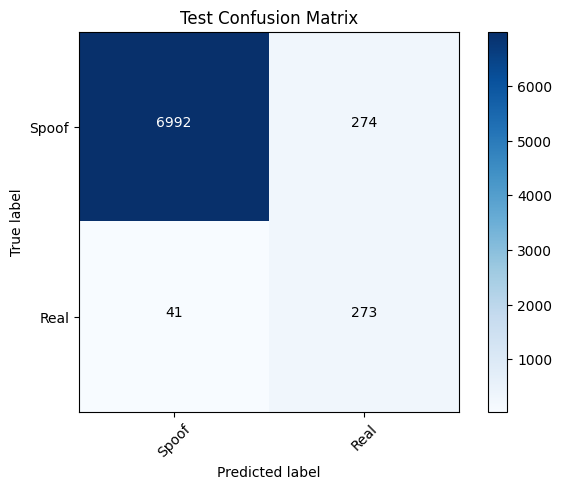

In [ ]:
cm = confusion_matrix(y_true=y_true_test, y_pred=y_pred_test)
classes = ['Spoof', 'Real']
plot_confusion_matrix(cm,
                      classes=classes,
                      percentify_numbers = False,
                      title="Test Confusion Matrix")

plt.show()

# **copy to my drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r '/content/resnet50_spoof_checkpoint' '/content/drive/MyDrive/SMARTHOME/Simple_spoof_checkpoint'